# CS156 Assignment 1

## 1. Data Description

### 1.1 Data Overview
The dataset used for this project was extracted from my personal **BeReal digital archive**. BeReal is a social media platform that encourages users to share candid, unfiltered moments by taking and posting photos from both their front and back phone cameras at a randomly prompted time each day. The data contains a collection of these moments, referred to as "memories," which include both visual and metadata elements.

### 1.2 Data Acquisition
The data was obtained through the **BeReal GDPR data request** process, which allows users to download all of their personal data stored by the platform. Upon requesting the data, BeReal provided a ZIP file containing several **JSON files** with information such as:
- **Photos** (front and back images)
- **Location data** (latitude, longitude)
- **Timestamps** (when the photos were taken)
- **Other metadata** (comments, reactions, user details)

For the purposes of this project, I focused on the **memories.json** file, which contains metadata related to my BeReal posts. The dataset includes a total of **955 memories**, each consisting of:
- Paths to the **front and back images** associated with each memory
- The **timestamp** indicating when each memory was captured
- **Location data** for posts where the app recorded latitude and longitude
- Whether the post was uploaded on time or late
- Any reactions or interactions from other users (not used in this analysis)

### 1.3 Sampling Strategy
The data used in this project covers my BeReal posts from the start of my account usage to the present, providing a complete set of moments captured over time. No additional sampling was necessary as the dataset was already constrained to my personal data archive.

The goal of this project is to analyze and model patterns from these posts, particularly focusing on whether I was with other people or alone at the time of each memory. The dataset was labeled with this information based on a manual inspection of each memory's front and back images, assigning a binary label (with_people or without_people) to each post.

## 2. Loading Data

In this section, the raw data from my **BeReal archive** is converted into a Python-readable format and loaded into a **pandas DataFrame** for further analysis. The primary dataset, memories.json, contains metadata about each memory, including image paths, timestamps, and location data.

The following steps were taken to load the data:
1. **Reading the JSON File**: The memories.json file was read using Python’s json module and then loaded into a pandas DataFrame for ease of manipulation and analysis.
2. **Image Paths**: The frontImage and backImage fields in the dataset contain the paths to the images associated with each memory. These paths were extracted and appended to the DataFrame for further processing.
3. **Timestamps and Location**: The timestamps (date and time of each post) and location data (latitude and longitude) were also extracted and added as new columns in the DataFrame.
4. **Handling Missing Data**: For some memories, location data was not recorded, so these values were set to NaN to handle them appropriately during analysis.

The loaded dataset is now structured in a pandas DataFrame, which will allow us to perform the necessary pre-processing, exploratory data analysis, and modeling in the upcoming sections.

In [1]:
import pandas as pd
import json

# Load the JSON file into a Python dictionary
with open('/Users/minjaekim/Projects/bereal-ml-project/data/iVkH1ljxruQMdiX6bixQvMbcJBu2-14RWaeP4zbC-mXBQf8Up7/memories.json') as f:
    memories_data = json.load(f)

# Create a list to store the relevant data for each memory
memories_list = []

# Loop through each memory and extract the relevant data
for memory in memories_data:
    front_image = memory['frontImage']['path']
    back_image = memory['backImage']['path']
    is_late = memory['isLate']
    date = memory['date']
    taken_time = memory['takenTime']
    bereal_moment = memory['berealMoment']
    # Use .get() to safely access the 'location' field, return None if not present
    location = memory.get('location', None)
    
    if location:
        latitude = location.get('latitude', None)
        longitude = location.get('longitude', None)
    else:
        latitude, longitude = None, None  # No location available
    
    # Add to the list as a dictionary
    memories_list.append({
        'front_image': front_image,
        'back_image': back_image,
        'is_late': is_late,
        'date': date,
        'taken_time': taken_time,
        'bereal_moment': bereal_moment,
        'latitude': latitude,
        'longitude': longitude
    })

# Convert the list of memories to a Pandas DataFrame
memories_df = pd.DataFrame(memories_list)

# Display the first few rows of the DataFrame
memories_df.head()

,front_image,back_image,is_late,date,taken_time,bereal_moment,latitude,longitude
0,/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2/post/UWat...,/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2/post/2ESG...,False,2024-10-08T00:00:00.000Z,2024-10-08T17:48:30.362Z,2024-10-08T17:48:05.346Z,37.790025,-122.401512
1,/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2/post/g6iG...,/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2/post/ITny...,True,2024-10-07T00:00:00.000Z,2024-10-08T02:08:28.988Z,2024-10-08T00:32:05.356Z,37.783693,-122.409564
2,/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2/post/FddJ...,/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2/post/H0_D...,False,2024-10-07T00:00:00.000Z,2024-10-08T02:18:18.197Z,2024-10-08T00:32:05.356Z,37.784089,-122.409181
3,/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2/post/aolL...,/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2/post/x6c-...,True,2024-10-06T00:00:00.000Z,2024-10-07T00:43:21.826Z,2024-10-06T20:51:05.354Z,37.784088,-122.409180
4,/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2/post/_F6f...,/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2/post/0fxu...,False,2024-10-06T00:00:00.000Z,2024-10-07T10:26:33.769Z,2024-10-06T20:51:05.354Z,37.784089,-122.409181


## 3. Data Wrangling

This section details the steps taken to clean, preprocess, and engineer features from the raw BeReal dataset. The steps are organized by topic for clarity, showing how each aspect of the data was handled. Additionally, the dataset was explored through visualizations and descriptive statistics to better understand its structure.

### 3.1 Initial Dataset Overview
Before proceeding with feature engineering and model building, the dataset was explored using:
- .info(): To inspect column data types and check for missing values.
- .isnull().sum(): To quantify missing values, especially in the location data (latitude and longitude).
- Percentage of Missing Data: Calculated the percentage of missing data in each column to better assess its scale and impact on the analysis.

In [8]:
print(memories_df.info())

print("\nNumber of values missing for each column:")
print(memories_df.isnull().sum())  # Check for missing values

# Calculate the percentage of missing data in each column
print("\nPercentage of missing data in each column:")
missing_percentage = (memories_df.isnull().sum() / len(memories_df)) * 100
print(missing_percentage[missing_percentage > 0])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   front_image    955 non-null    object 
 1   back_image     955 non-null    object 
 2   is_late        955 non-null    bool   
 3   date           955 non-null    object 
 4   taken_time     955 non-null    object 
 5   bereal_moment  955 non-null    object 
 6   latitude       809 non-null    float64
 7   longitude      809 non-null    float64
dtypes: bool(1), float64(2), object(5)
memory usage: 53.3+ KB
None

Number of values missing for each column:
front_image        0
back_image         0
is_late            0
date               0
taken_time         0
bereal_moment      0
latitude         146
longitude        146
dtype: int64

Percentage of missing data in each column:
latitude     15.287958
longitude    15.287958
dtype: float64


### 3.2 Handling Image Data
The raw dataset included image paths that did not match the structure of the provided zip file. To correct this, the image paths were adjusted to match the actual folder structure. Afterward, the first five images were displayed to verify that the paths were correct.

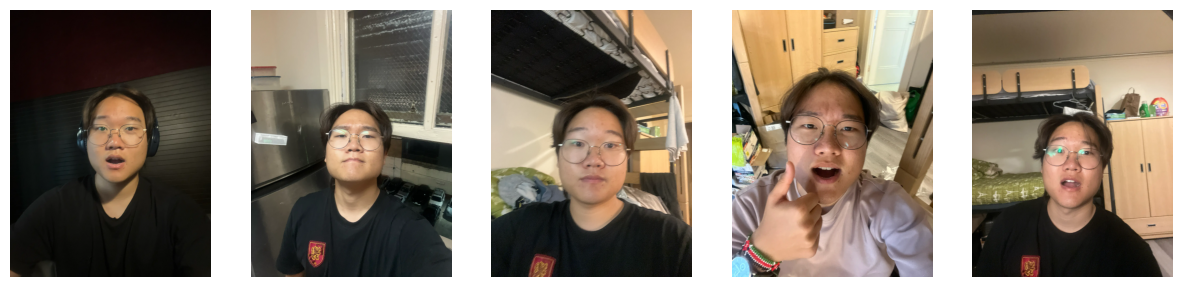

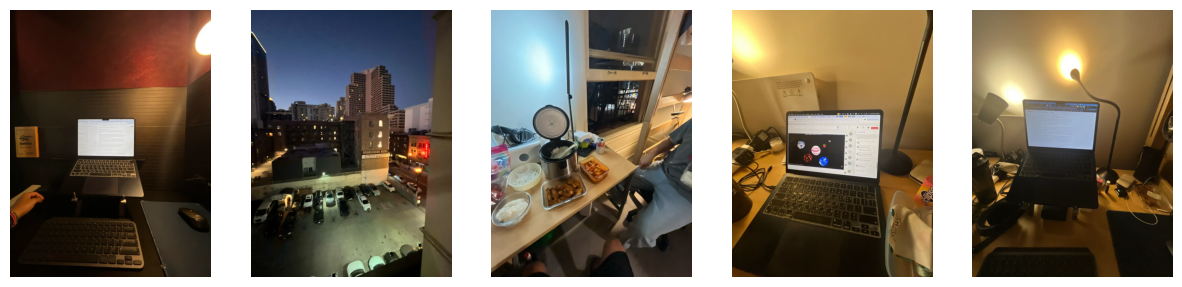

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

# Function to display images
def display_images(image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    for ax, image_path in zip(axes, image_paths):
        img = Image.open(image_path)  # Open the image from the local file
        ax.imshow(img)  # Display the image
        ax.axis('off')  # Remove axes
    plt.show()

# Correct the image paths in the DataFrame by replacing '/Photos/' with 'data/Photos/'
memories_df['front_image'] = memories_df['front_image'].apply(lambda x: x.replace('/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2', '/Users/minjaekim/Projects/bereal-ml-project/data/iVkH1ljxruQMdiX6bixQvMbcJBu2-14RWaeP4zbC-mXBQf8Up7/Photos'))
memories_df['back_image'] = memories_df['back_image'].apply(lambda x: x.replace('/Photos/iVkH1ljxruQMdiX6bixQvMbcJBu2', '/Users/minjaekim/Projects/bereal-ml-project/data/iVkH1ljxruQMdiX6bixQvMbcJBu2-14RWaeP4zbC-mXBQf8Up7/Photos'))

# Get the first 5 front images from the DataFrame
front_image_paths = memories_df['front_image'].head(5)
back_image_paths = memories_df['back_image'].head(5)

# Display the first 5 front images
display_images(front_image_paths)
display_images(back_image_paths)

### 3.3 Location-Based Analysis
Using Folium, the geographical locations of memories were plotted on a map to visualize the spatial distribution. Additionally, missing location data were removed to ensure the visualization works as expected.

In [4]:
import folium

# Initialize a map at a central location
m = folium.Map(location=[memories_df['latitude'].mean(), memories_df['longitude'].mean()], zoom_start=5)

# Add markers for each BeReal post
for i, row in memories_df.iterrows():
    if not pd.isnull(row['latitude']) and not pd.isnull(row['longitude']):
        folium.Marker([row['latitude'], row['longitude']], popup=row['bereal_moment']).add_to(m)

# Show the map
m


### 3.4 On-Time vs. Late Posts
A bar chart was plotted to compare the number of on-time vs. late posts, providing insights into the distribution of posts relative to the platform’s daily prompt.

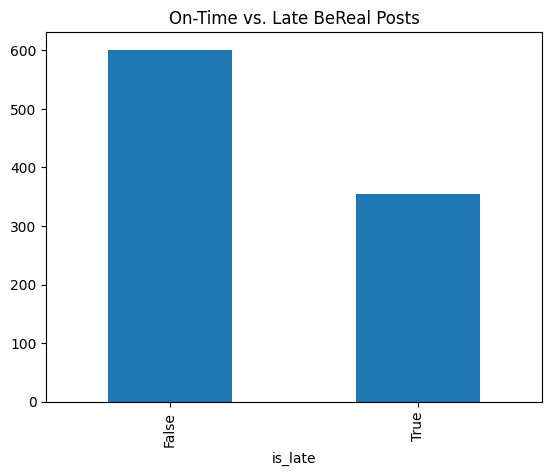

In [5]:
# Plot the count of 'on-time' vs 'late' posts
memories_df['is_late'].value_counts().plot(kind='bar', title='On-Time vs. Late BeReal Posts')
plt.show()


### 3.5 Time-Based Feature Engineering
To prepare for further time-based analysis, two new features were engineered:
- day_of_week: Extracted from the takenTime column to indicate the day of the week when the memory was captured.
- hour_of_day: Created to represent the hour of the day when the memory was posted.

The following visualizations were created:
- Day of the Week Distribution: A bar plot showing the number of memories posted on each day of the week.
- Hour of the Day Distribution: A histogram showing the distribution of posts across different times of the day.

In [23]:
# Convert the 'takenTime' column to datetime
memories_df['taken_time'] = pd.to_datetime(memories_df['taken_time'])

# Now you can access .dt attributes for time-based exploration
memories_df['day_of_week'] = memories_df['taken_time'].dt.day_name()
memories_df['hour_of_day'] = memories_df['taken_time'].dt.hour

# Display the new columns to check
print(memories_df[['taken_time', 'day_of_week', 'hour_of_day']].tail())



                          taken_time day_of_week  hour_of_day
950 2022-08-03 17:48:52.664000+00:00   Wednesday           17
951 2022-08-02 12:33:01.780000+00:00     Tuesday           12
952 2022-08-01 22:03:56.966000+00:00      Monday           22
953 2022-07-31 14:55:15.583000+00:00      Sunday           14
954 2022-07-27 18:43:39.214000+00:00   Wednesday           18


,latitude,longitude,hour_of_day
count,809.000000,809.000000,955.000000
mean,22.935719,56.221830,10.743455
std,17.799800,81.492029,5.688282
min,-24.016484,-122.471753,0.000000
25%,-1.277712,36.784795,7.000000
50%,37.178842,78.369480,10.000000
75%,37.559110,127.146865,15.000000
max,53.218858,140.384923,23.000000


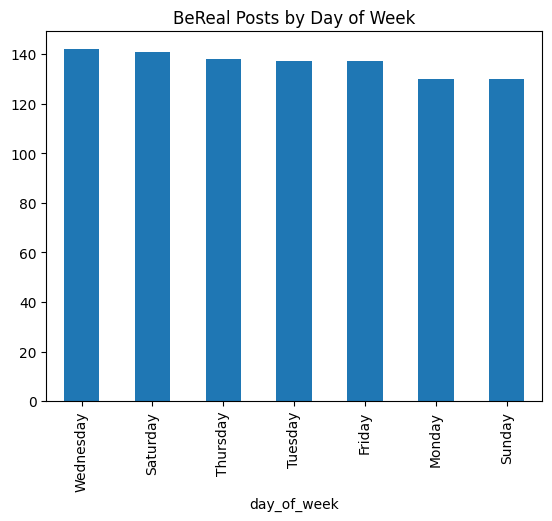

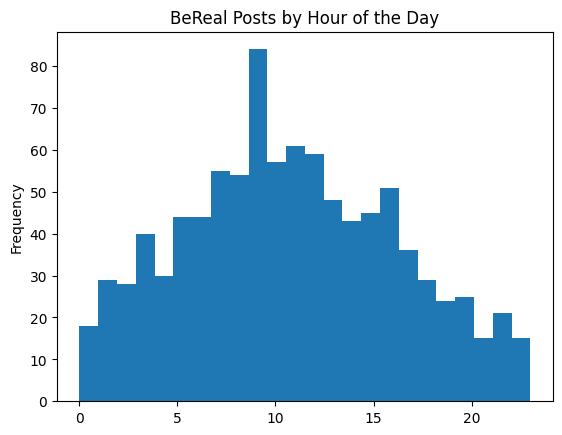

In [7]:
# Plot distribution of BeReal moments by day of the week
memories_df['day_of_week'].value_counts().plot(kind='bar', title='BeReal Posts by Day of Week')
plt.show()

# Plot distribution by hour of the day
memories_df['hour_of_day'].plot(kind='hist', bins=24, title='BeReal Posts by Hour of the Day')
plt.show()


### 3.6 Labeling the Data
Each memory was manually labeled with a new binary feature, is_with_people, indicating whether other people were present in the post. This labeling was performed through manual inspection of both the front and back images associated with each memory.

In [8]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# Assuming you have a DataFrame named 'memories_df'
# We will add a new column 'is_with_people' that you'll manually label
memories_df['is_with_people'] = None  # Placeholder for manual labeling

# Create widgets for labeling
label_widget = widgets.ToggleButtons(
    options=[True, False],
    description='With People:'
)

save_button = widgets.Button(description="Save Label")
image_index = 0

# Display the first image or relevant metadata
img_display = widgets.Output()

def show_memory(index):
    with img_display:
        clear_output(wait=True)
        print(f"Memory {index+1} out of {len(memories_df)}")
        print(f"Front Image Path: {memories_df.loc[index, 'front_image']}")
        print(f"Back Image Path: {memories_df.loc[index, 'back_image']}")
        print(f"Location: {memories_df.loc[index, 'latitude']}, {memories_df.loc[index, 'longitude']}")
        print(f"Date/Time: {memories_df.loc[index, 'taken_time']}")
        # You can also display the images here using libraries like PIL or OpenCV, if needed.
        # Get the paths for the front and back images
        front_image_path = memories_df.loc[index, 'front_image']
        back_image_path = memories_df.loc[index, 'back_image']
        
        # Open the images using PIL
        img1 = Image.open(front_image_path)
        img2 = Image.open(back_image_path)

        # Display images side by side
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create 1 row, 2 columns
        axs[0].imshow(img1)
        axs[0].axis('off')  # Hide axis
        axs[0].set_title('Front Image')

        axs[1].imshow(img2)
        axs[1].axis('off')  # Hide axis
        axs[1].set_title('Back Image')

        plt.show()

# Function to save the label for the current memory
def save_label(b):
    global image_index
    # Save the label to the DataFrame
    memories_df.loc[image_index, 'is_with_people'] = label_widget.value
    
    # Move to the next image
    image_index += 1
    if image_index < len(memories_df):
        show_memory(image_index)  # Show the next memory
    else:
        with img_display:
            clear_output()
            print("All memories labeled!")

# Display the widgets
save_button.on_click(save_label)
display(img_display)
show_memory(image_index)
display(label_widget, save_button)


Output()

ToggleButtons(description='With People:', options=(True, False), value=True)

Button(description='Save Label', style=ButtonStyle())

In [13]:
# Extracting labeled data to labeled_memories.csv
# memories_df.to_csv('labeled_memories.csv', index=False) 
# Commented out because this only needs to be done once right after the first time the labeling is completed.

# Loading previously labeled memories data
labeled_memories_df = pd.read_csv("/Users/minjaekim/Projects/bereal-ml-project/data/iVkH1ljxruQMdiX6bixQvMbcJBu2-14RWaeP4zbC-mXBQf8Up7/labeled_memories.csv")

### 3.7 Analysis of Labeled Data
After labeling the data, additional analysis was conducted to understand the distribution of posts labeled as with_people or without_people and their relationships with other features:
- Distribution of Posts: A bar chart was created to show the count of posts labeled as "with people" and "without people."
- Cross-Analysis: The relationship between the is_with_people label and features like time of day and location was explored, looking for patterns in social behavior.
- Correlation Matrix: A heatmap was plotted to examine the correlations between the features and the is_with_people label to identify potential predictive relationships.

#### 3.7.1 Distribution of Posts

/var/folders/r0/68n8gcdd48vgkv5r026jhnlh0000gn/T/ipykernel_42312/2368375072.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_with_people', data=labeled_memories_df, palette='Set2')


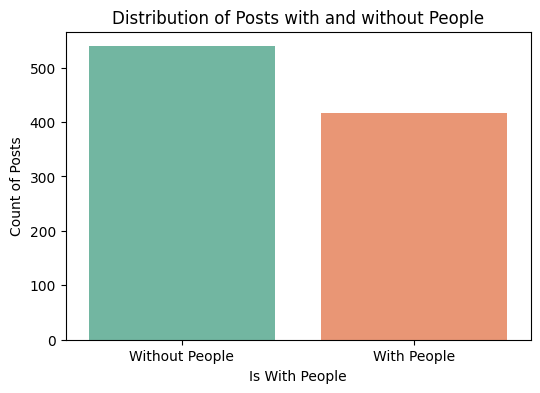

In [14]:
import seaborn as sns

# Count of posts labeled as "with people" and "without people"
plt.figure(figsize=(6, 4))
sns.countplot(x='is_with_people', data=labeled_memories_df, palette='Set2')
plt.title('Distribution of Posts with and without People')
plt.xlabel('Is With People')
plt.ylabel('Count of Posts')
plt.xticks([0, 1], ['Without People', 'With People'])
plt.show()

#### 3.7.2 Cross-Analysis

/var/folders/r0/68n8gcdd48vgkv5r026jhnlh0000gn/T/ipykernel_42312/752509882.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_with_people', y='hour_of_day', data=labeled_memories_df, palette='Set2')


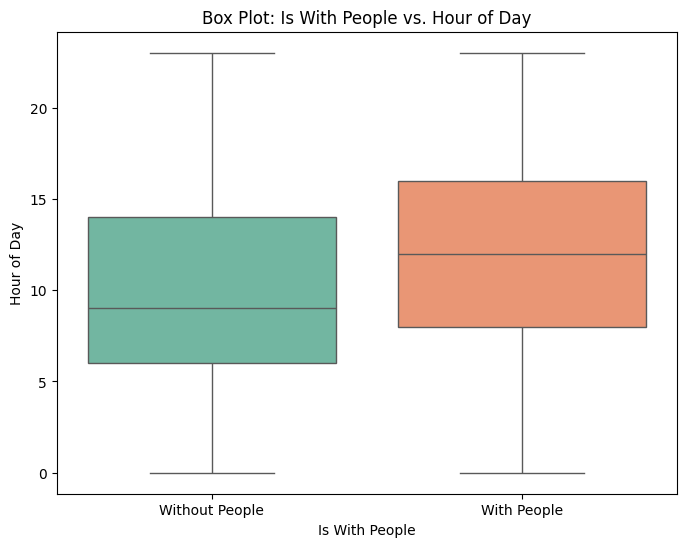

In [16]:
# Box plot of is_with_people vs hour_of_day
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_with_people', y='hour_of_day', data=labeled_memories_df, palette='Set2')
plt.title('Box Plot: Is With People vs. Hour of Day')
plt.xlabel('Is With People')
plt.ylabel('Hour of Day')
plt.xticks([0, 1], ['Without People', 'With People'])
plt.show()


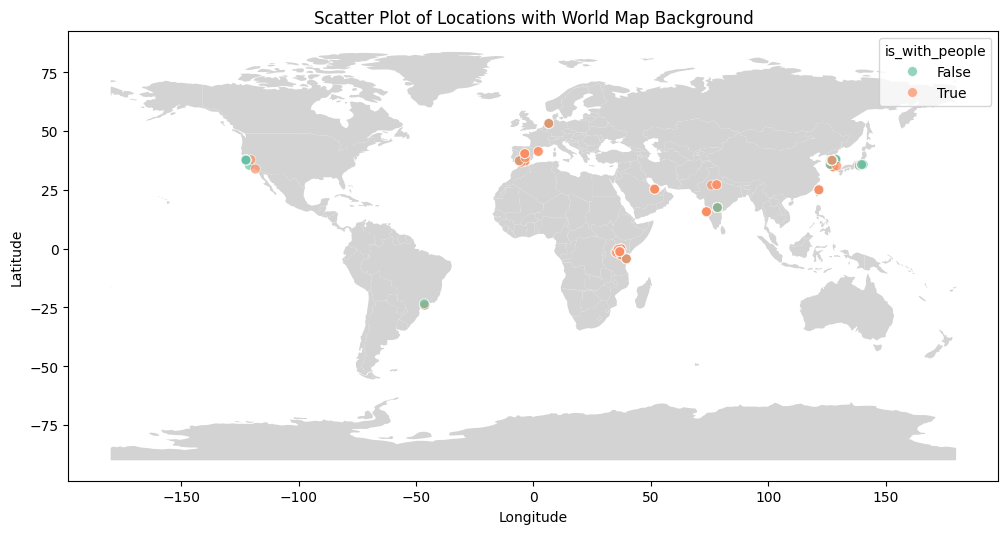

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Load world map from GeoPandas
world = gpd.read_file('/Users/minjaekim/Projects/bereal-ml-project/data/ne_110m_admin_0_countries')

# Create a GeoDataFrame for your memories dataset
gdf = gpd.GeoDataFrame(labeled_memories_df, geometry=gpd.points_from_xy(labeled_memories_df['longitude'], labeled_memories_df['latitude']))

# Plot the world map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgray')

# Plot the scatter points on the map
sns.scatterplot(x='longitude', y='latitude', hue='is_with_people', data=labeled_memories_df, ax=ax, s=50, alpha=0.7, palette='Set2')

# Set titles and labels
plt.title('Scatter Plot of Locations with World Map Background')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


#### 3.7.3 Correlation Matrix

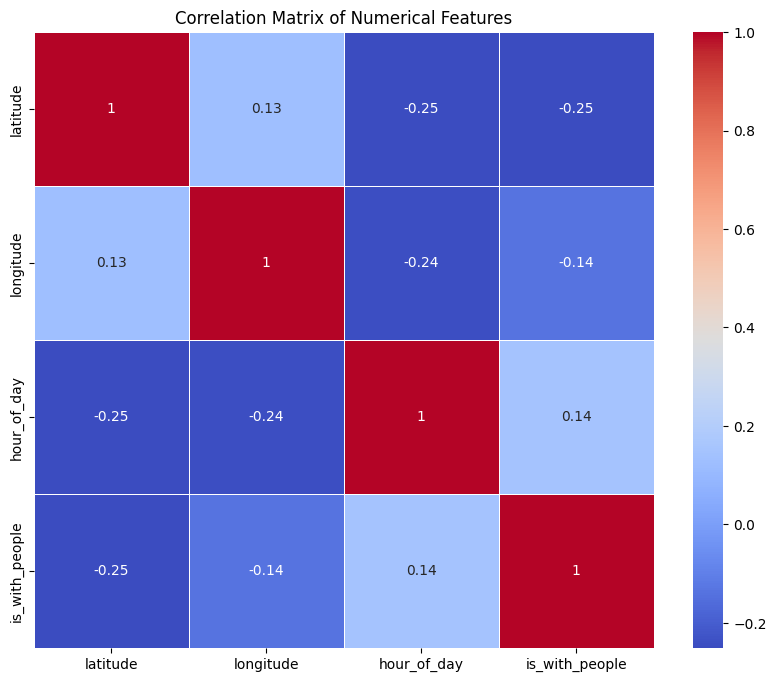

In [21]:
# Correlation matrix and heatmap
plt.figure(figsize=(10, 8))
corr_matrix = labeled_memories_df[['latitude', 'longitude', 'hour_of_day', 'is_with_people']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


## 5. Data splitting

In [11]:
labeled_memories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   front_image     955 non-null    object 
 1   back_image      955 non-null    object 
 2   is_late         955 non-null    bool   
 3   date            955 non-null    object 
 4   taken_time      955 non-null    object 
 5   bereal_moment   955 non-null    object 
 6   latitude        809 non-null    float64
 7   longitude       809 non-null    float64
 8   day_of_week     955 non-null    object 
 9   hour_of_day     955 non-null    int64  
 10  is_with_people  955 non-null    bool   
dtypes: bool(2), float64(2), int64(1), object(6)
memory usage: 69.1+ KB


In [12]:
from sklearn.model_selection import train_test_split

# Drop rows with NaN values in the features or target
memories_df_cleaned = labeled_memories_df.dropna()

# Define the features (X) and the target variable (y)
X = memories_df_cleaned[['latitude', 'longitude', 'hour_of_day', 'day_of_week', 'is_late']]
# For 'day_of_week', encoding it since it's categorical
X = pd.get_dummies(X, columns=['day_of_week'])
y = memories_df_cleaned['is_with_people']  # Target column

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(647, 11) (162, 11) (647,) (162,)


In [13]:
# Convert y_train and y_test to integers (0 for False, 1 for True)
y_train = y_train.astype(int)
y_test = y_test.astype(int)



## 6. Modeling

### 6.1 Logistic Regression

#### Training

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)


#### Evaluation

In [15]:
# Make predictions on the test data
y_pred = model.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.56
Confusion Matrix:
[[57 28]
 [43 34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        85
           1       0.55      0.44      0.49        77

    accuracy                           0.56       162
   macro avg       0.56      0.56      0.55       162
weighted avg       0.56      0.56      0.56       162



### 6.2 Gaussian Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the Gaussian Naive Bayes model
nb_model = GaussianNB()

# Train the model on the training data
nb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.55
Confusion Matrix:
[[51 34]
 [39 38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.60      0.58        85
           1       0.53      0.49      0.51        77

    accuracy                           0.55       162
   macro avg       0.55      0.55      0.55       162
weighted avg       0.55      0.55      0.55       162



### 6.3 Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)


In [19]:
# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.72
Confusion Matrix:
[[63 22]
 [24 53]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        85
           1       0.71      0.69      0.70        77

    accuracy                           0.72       162
   macro avg       0.72      0.71      0.71       162
weighted avg       0.72      0.72      0.72       162



In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],          # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],            # Minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2']           # Number of features to consider at each split
}

# Initialize GridSearchCV with RandomForestClassifier
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
print(f"Best Parameters: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the tuned model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"Tuned Random Forest Accuracy: {accuracy_best_rf:.2f}")

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_best_rf))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=

/Users/minjaekim/Projects/bereal-ml-project/venv/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


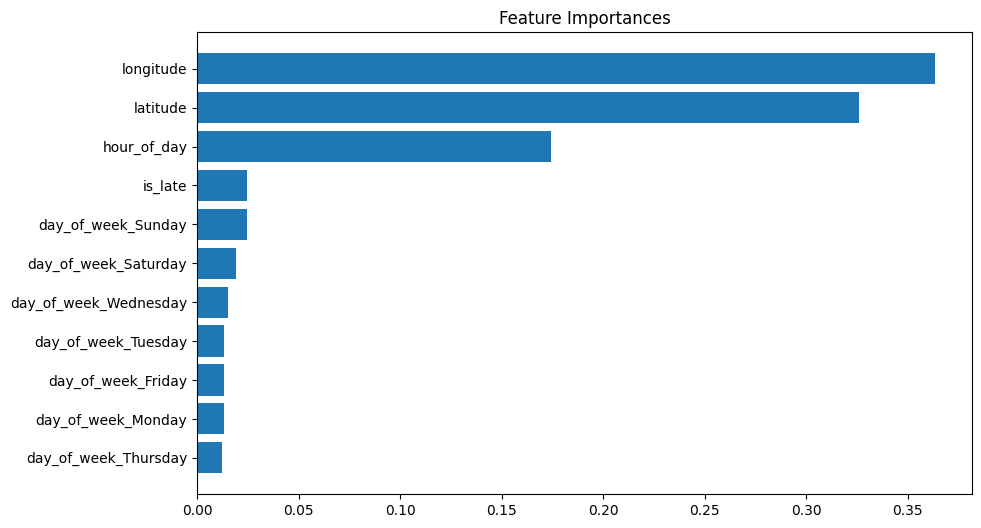

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feature importance from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Plot feature importance
features = X_train.columns  # Original features
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), feature_importances[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()


### Considerations

Considerations:
- DONE Logistic regression for whether a post is late or not late
- DONE Label whether I am with or without people
    - With people is true only when people are in person and I am associated with them. Screens don't count, and people that I do not know do not count.
    - Mistake august 8, 2024. 
    - actually messed up august 17 2023, august 13, july 4 2023, june 15 2023, march 13 2023, november 16 2022
    - may 28 2023 missing
- Do some more EDA with the new label. Talk with ChatGPT about it.
- Double check with evaluation metric to ensure there is variety.
- Write equations and formulas and other things that go into explaining what's going on behind each of the models. 
- Ask GPT about Naive bayes with softmax
- Start the actual write-up

Labeling is done now so I can start modeling. 


Write up notes:
- I need to write the description for the data wrangling section to match the code. This may also need readjusting the order of the code. I think this should be done in a way that helps with clear organization rather than strictly following chronological order of how things were done.